In [35]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from uncertainties import ufloat

data = pd.read_csv( 'data.csv')

In [36]:
def create_spline( x, y, xmin, xmax, xerr, yerr, fmt, color, text=''):
  xax = np.linspace( xmin, xmax, 1000)
  p, cov = np.polyfit( x, y, deg=3, cov=True)

  cov = np.sqrt( np.diag( cov))

  plt.errorbar( x, y, xerr=xerr, yerr=yerr, fmt=fmt)
  plt.plot( xax,
            p[0] * xax**3 + p[1] * xax**2 + p[2] * xax + p[3],
            color=color, label=text)

  return [p, cov]

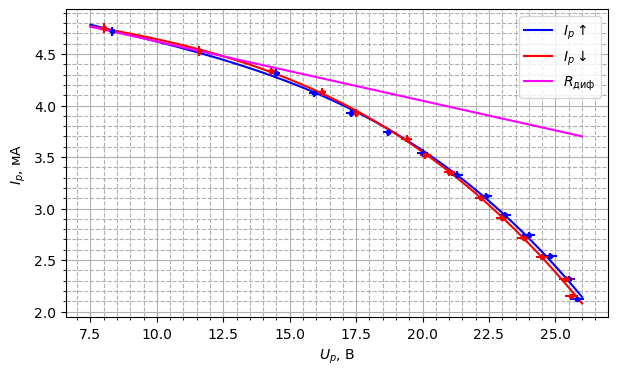

In [37]:
Ip = data['Ip, мА']
Up = data['Up, В']

EPS = 0.01

Ierr = Ip * EPS
Uerr = Up * EPS

PEAK_IDX = 14

plt.figure( figsize=(7, 4))

create_spline( Up[:PEAK_IDX], Ip[:PEAK_IDX],
               xmin=7.5, xmax=26,
               xerr=Uerr[:PEAK_IDX], yerr=Ierr[:PEAK_IDX],
               fmt='b.', color='blue', text='$I_p\\uparrow$')

create_spline( Up[PEAK_IDX:], Ip[PEAK_IDX:],
               xmin=7.5, xmax=26,
               xerr=Uerr[PEAK_IDX:], yerr=Ierr[PEAK_IDX:],
               fmt='r.', color='red', text='$I_p\\downarrow$')

# касательная и дифференциальное напряжение
slope = (ufloat( Ip[PEAK_IDX - 2], Ierr[PEAK_IDX - 2])
- ufloat( Ip[PEAK_IDX - 1], Ierr[PEAK_IDX - 1])) / (ufloat( Up[PEAK_IDX - 2], Uerr[PEAK_IDX - 2]) - ufloat( Up[PEAK_IDX - 1], Uerr[PEAK_IDX - 1]))
inter = Ip[PEAK_IDX - 1] - slope.nominal_value * Up[PEAK_IDX - 1]

xax = np.linspace( 7.5, 26, 1000)
plt.plot( xax, slope.nominal_value * xax + inter,
          color='magenta', label='$R_{\\text{диф}}$')

R_dif = 1 / slope

plt.xlabel( '$U_p$, В')
plt.ylabel( '$I_p$, мА')
plt.grid( which='major', linestyle='-')
plt.grid( which='minor', linestyle='--')
plt.minorticks_on()
plt.legend()

plt.savefig( 'vah.pdf')

In [38]:
R_dif

-17.368421052631618+/-6.027263674163185

In [39]:
# I(U) - зондовые характеристики
U = []
I = []

for i in range (1, 4):
  U.append( list( data[f'U+{i}, В'])   + list( -data[f'U-{i}, В']))
  I.append( list( data[f'I+{i}, мкА']) + list( -data[f'I-{i}, мкА']))

In [40]:
def clear_from_nans( arr):
  arr = np.array( arr)
  arr = arr[~np.isnan( arr)]
  return arr

In [45]:
from scipy.optimize import curve_fit

def plot_zond(x, y, xerr=0, yerr=0, color='blue', label='', fmt=''):
  plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt=fmt)
  volt = lambda u, a, b: a * np.tanh( b * u)

  xax = np.linspace( min(x), max(x), 1000)
  #print( y.size)

  popt, pcov = curve_fit( volt, xdata=x, ydata=y)
  plt.plot( xax, volt( xax, *popt), color=color, label=label)

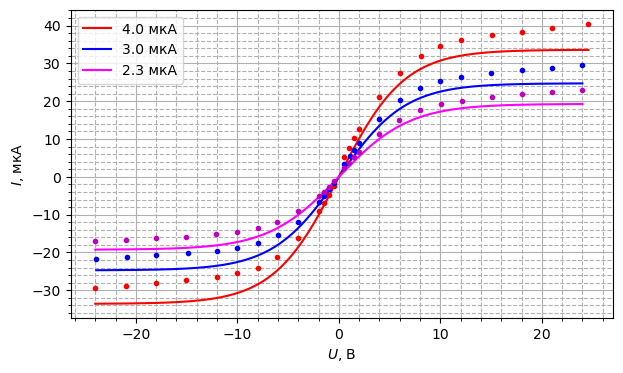

In [46]:
plt.figure(figsize=(7, 4))

colors = ['red', 'blue', 'magenta']
fmts   = ['r.' , 'b.'  , 'm.']
labels = ['4.0 мкА', '3.0 мкА', '2.3 мкА']

for i in range( len(U)):
  U[i] = clear_from_nans( U[i])
  I[i] = clear_from_nans( I[i])
  #print( I[i])
  plot_zond( U[i], I[i], xerr=0, yerr=0, color=colors[i], label=labels[i], fmt=fmts[i])

plt.grid( which='major', linestyle='-')
plt.grid( which='minor', linestyle='--')
plt.minorticks_on()
plt.xlabel( '$U$, В')
plt.ylabel( '$I$, мкА')
plt.legend()
plt.savefig( 'zond.pdf')